In [1]:
from survival_analysis import prepare_df, obtain_survival_fractions, obtain_total_alive_count
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from scipy.integrate import quad

In [2]:
df = prepare_df()

In [3]:
df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


[0.12218057 0.05819898 8.97407875 9.99474502]


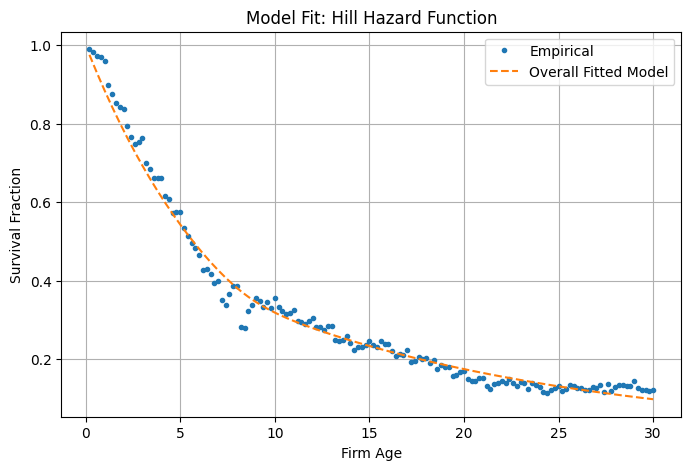

In [4]:
# ---- Step 1: Define the Hill-type hazard function ----

def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)  # Add epsilon to avoid div by 0

# ---- Step 2: Define survival function S(a) using quad integration ----

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

# ---- Step 3: Vectorized function to compute model survival over array of ages ----

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

# ---- Step 4: Objective function to minimize squared error between model and empirical ----

def objective_hill(params, ages, observed_survival):
    mu_ub, mu_lb, K, m = params
    if mu_ub < mu_lb or mu_ub < 0 or mu_lb < 0:
        return np.inf
    predicted = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    return np.sum((predicted - observed_survival)**2)

# ---- Step 5: Fit parameters ----

def fit_survival_model(ages, survival_fractions, initial_guess=[0.1, 0.05, 5, 10]):
    '''
    Returns the params of the Hill function model giving the least squares error

    Inputs:
    ages = firm age bins
    survival_fractions = survival fraction of firms in each age bin
    initial_guess = initial guess for params [mu_ub, mu_lb, K, m]

    ''' 
    bounds = [(0.01, 0.3), (1e-10, 0.3), (0.1, 30), (0.5, 100)]
    result = minimize(objective_hill, initial_guess, args=(ages, survival_fractions), bounds=bounds)
    return result

# ---- Step 6: Example usage with your data ----

# Create age bins (e.g., every 2 years)
bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)


# Compute survival fraction per bin
surv_frac = df_analysis.groupby('age_bin', observed=True)['status'].mean().reset_index()
surv_frac = surv_frac.loc[~(surv_frac == 0).any(axis=1)]
survival_fractions = np.array(surv_frac['status'])
ages = surv_frac['age_bin'].apply(lambda x: x.right)

result = fit_survival_model(ages, survival_fractions, [0.2, 0.05, 5, 10])
best_params = result.x
overall_predicted_curve = model_survival_curve_hill(ages, *best_params)
print(best_params)

# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.plot(ages, survival_fractions, 'o', markersize = 3, label="Empirical")
plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
plt.xlabel("Firm Age")
plt.ylabel("Survival Fraction")
plt.title("Model Fit: Hill Hazard Function")
plt.grid(True)
plt.legend()
plt.show()

[ 0.10698768  0.07005167 12.27841214  5.29302687]


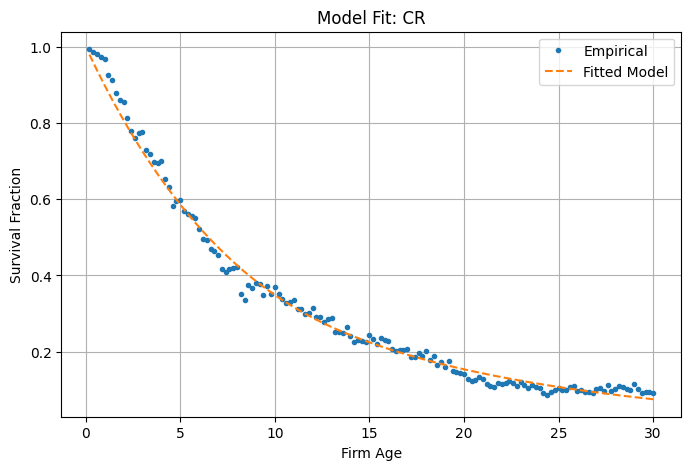

In [5]:
survival_frac, ages = obtain_survival_fractions(df_analysis, 'Region', 'CR')

result = fit_survival_model(ages, survival_frac, [0.2, 0.05, 5, 5])
best_params = result.x
predicted_curve = model_survival_curve_hill(ages, *best_params)
print(best_params)

# Plot model against empirical
plt.figure(figsize=(8, 5))
plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
plt.plot(ages, predicted_curve, '--', label="Fitted Model")
plt.xlabel("Firm Age")
plt.ylabel("Survival Fraction")
plt.title(f"Model Fit: {'CR'}")
plt.grid(True)
plt.legend()
plt.show()

In [6]:
region_list = ['NR','WR','CR','ER','NER']

for region in region_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Region', region)
    result = fit_survival_model(ages, survival_frac, [0.2, 0.05, 8, 7])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(f'{region}: {best_params}')

    # # Plot model against empirical
    # plt.figure(figsize=(8, 5))
    # plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    # plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    # plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    # plt.xlabel("Firm Age")
    # plt.ylabel("Survival Fraction")
    # plt.title(f"Model Fit: {region}")
    # plt.grid(True)
    # plt.legend()
    # plt.show()

NR: [0.13574074 0.01468059 8.98681513 6.98910326]
WR: [1.38430190e-01 2.40740341e-02 8.60832150e+00 1.00000000e+02]
CR: [ 0.10726301  0.07506882 10.92019458  7.17313311]
ER: [0.14417409 0.02666826 9.64267205 7.01975396]
NER: [1.49820212e-01 3.71745012e-02 8.25942813e+00 1.00000000e+02]


F: [7.95451385e-02 1.00000000e-10 2.86208538e+01 1.20016355e+01]


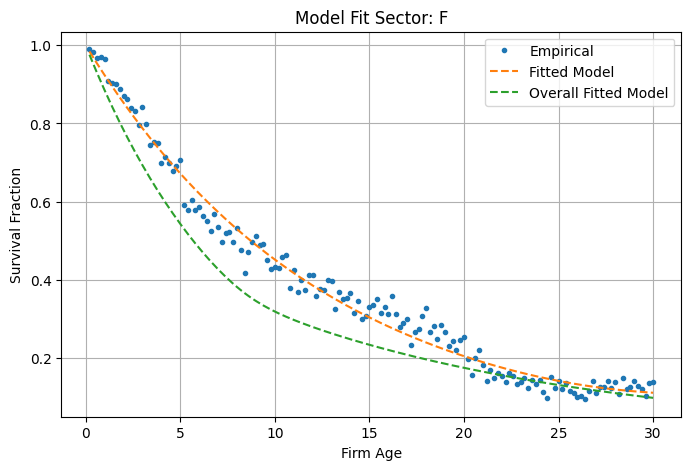

L: [7.57562545e-02 5.85672639e-03 2.61705419e+01 1.00001744e+01]


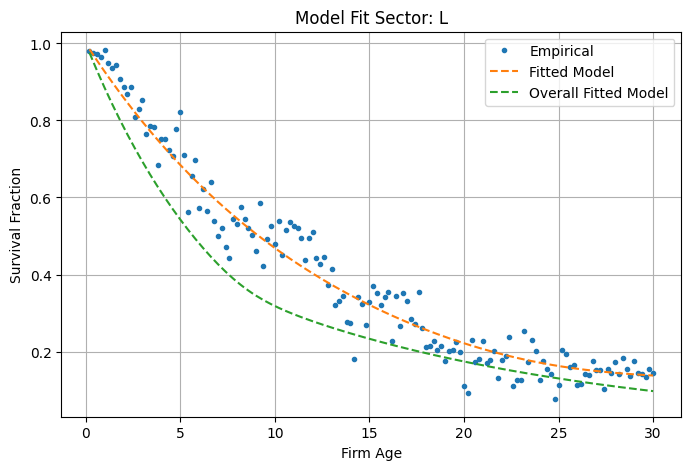

In [7]:
sector_list = ['F', 'L']

for sector in sector_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    result = fit_survival_model(ages, survival_frac, [0.07998763144579782, 0.01, 26.17074846209418, 10.0])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(f'{sector}: {best_params}')

    # Plot model against empirical
    plt.figure(figsize=(8, 5))
    plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    plt.xlabel("Firm Age")
    plt.ylabel("Survival Fraction")
    plt.title(f"Model Fit Sector: {sector}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [8]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']

for sector in sector_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    result = fit_survival_model(ages, survival_frac, [0.2, 0.03, 9, 5])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(f'{sector}: {best_params}')

    # # Plot model against empirical
    # plt.figure(figsize=(8, 5))
    # plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    # plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    # plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    # plt.xlabel("Firm Age")
    # plt.ylabel("Survival Fraction")
    # plt.title(f"Model Fit Sector: {sector}")
    # plt.grid(True)
    # plt.legend()
    # plt.show()

G: [ 0.13557519  0.06119442  9.91855101 28.37901804]
M: [ 0.1097038   0.04915758 11.80623607  5.40536658]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


F: [0.1427709  0.02096383 8.82787014 4.98418077]
J: [ 0.13237394  0.05570531  9.59637699 10.65350551]
K: [7.23783498e-02 6.42624125e-03 1.74452097e+01 7.90755902e+00]
C: [1.01329542e-01 4.86099066e-02 8.52078240e+00 1.00000000e+02]
H: [1.56593834e-01 4.61012037e-02 6.90836250e+00 1.00000000e+02]
S: [1.40395122e-01 1.00000000e-10 1.29034246e+01 5.10492401e+00]
N: [1.23256986e-01 1.00000000e-10 1.62314002e+01 3.93349967e+00]
I: [1.27228077e-01 1.00000000e-10 2.07384939e+01 3.73566674e+00]
P: [1.21430444e-01 6.70227955e-02 9.47949818e+00 1.00000000e+02]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


L: [0.14010446 0.02054281 8.80146452 4.98057058]
Q: [7.87172720e-02 4.78399527e-02 7.56229192e+00 1.00000000e+02]
R: [1.33210761e-01 8.40125453e-02 8.82538519e+00 1.00000000e+02]


In [9]:
# Negative log-likelihood for binomial MLE
def neg_log_likelihood_hill(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

# Fit function
def fit_hill_model_mle(ages, survivors, totals, initial_guess=[0.3, 0.01, 5.0, 2.0]):
    '''
    ages = vector of ages
    survivors = number of survivors in age bin
    totals = total number of firms in age bin
    initial_guess = [mu_ub, mu_lb, K, m]

    returns best params according to MLE
    
    '''
    bounds = [(0.01, 0.3), (1e-10, 0.3), (0.01, 30), (0.5, 100)]
    result = minimize(neg_log_likelihood_hill, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result.x


In [30]:
region_ll_hill = []
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals)
    
    print(f'{fil} {[float(x) for x in [mu_ub, mu_lb, K, m]]}')    

    # # Plot fit
    # fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    # print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')
    region_ll_hill.append(neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))

    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    # plt.title(f'MLE Hill fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


NR [0.136997519985397, 0.02355779154418483, 8.313803127053902, 100.0]
WR [0.13907876081827764, 0.02564048511268826, 8.486260225229435, 100.0]
CR [0.10404007532758659, 0.050558263421044906, 17.32386546517892, 5.549887979024525]
ER [0.14743284942552679, 0.03815357128949517, 8.49964983319687, 100.0]
NER [0.1515383757283376, 0.03569624892822053, 8.275610738471816, 100.0]


ll for F: -47800.28245812628
params mu_ub, mu_lb, K, m are [0.08, 0.001, 27.0, 8.0]


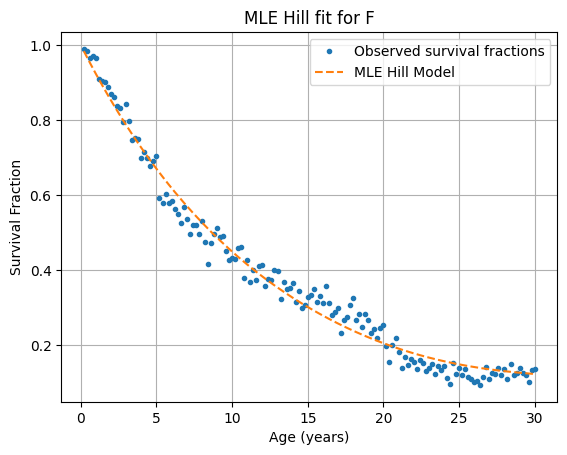

ll for K: -56212.87737841369
params mu_ub, mu_lb, K, m are [0.07012013444682985, 0.011071032156307387, 17.600632045539754, 11.7197538927883]


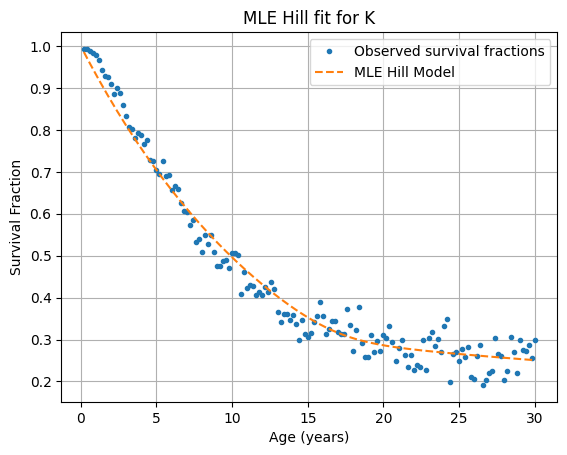

ll for H: -50669.904189963505
params mu_ub, mu_lb, K, m are [0.08, 0.001, 27.0, 8.0]


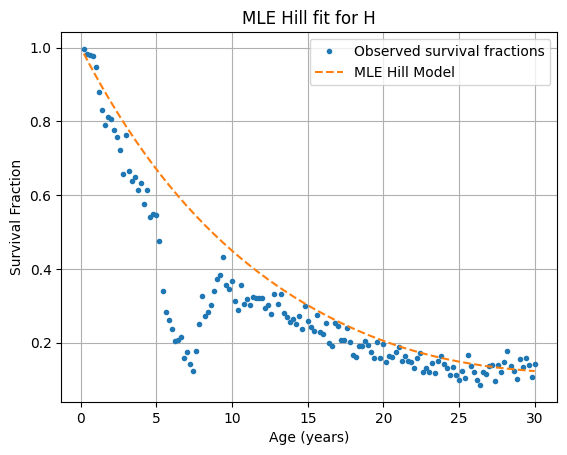

ll for L: -11922.18775744128
params mu_ub, mu_lb, K, m are [0.0742352881373648, 1e-10, 28.271301336276377, 8.561583065547653]


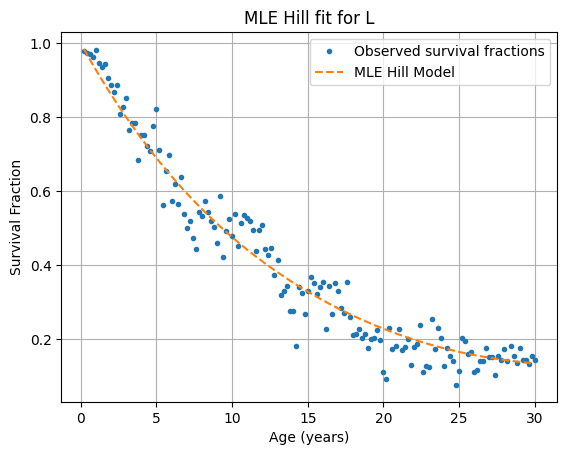

In [11]:
sector_list = ['F', 'K', 'H', 'L']
for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals, [0.08, 0.001, 27, 8])
    print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')

    # Plot fit
    fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    print(f'params mu_ub, mu_lb, K, m are {[float(x) for x in [mu_ub, mu_lb, K, m]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    plt.title(f'MLE Hill fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

    #-48281.75199323837

G: [ 0.13660027  0.03574423 12.39113424  4.14356328]
ll for G: -198383.82688326662


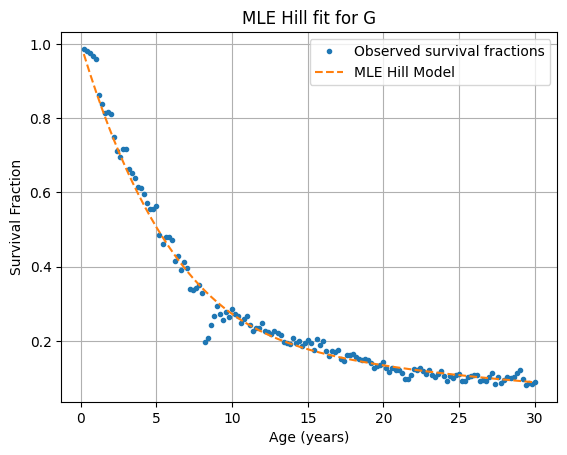

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


M: [ 0.10877533  0.0418096  12.55269306  4.41391222]
ll for M: -106918.42641481012


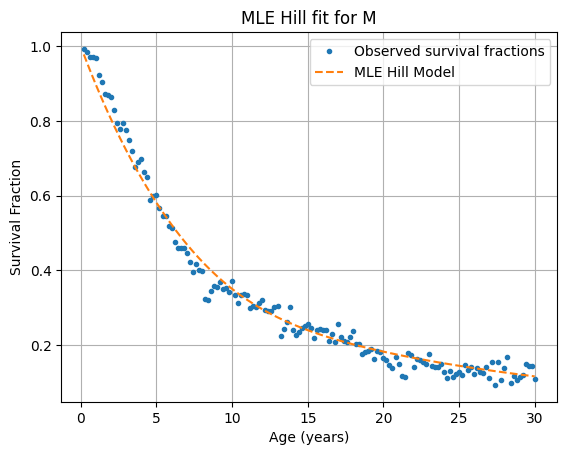

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


F: [ 0.13397865  0.07941962  2.91343986 42.96844049]
ll for F: -48530.51677959216


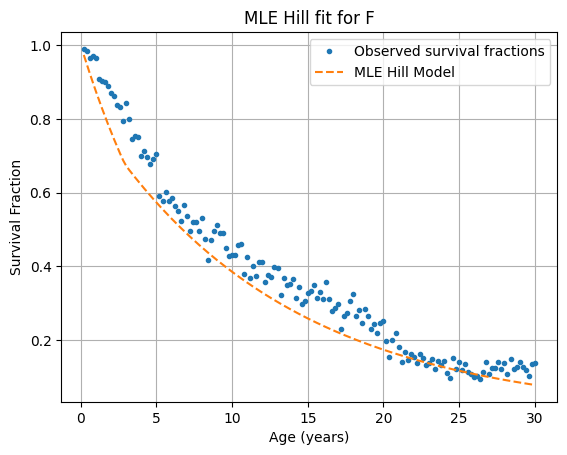

J: [ 0.13090805  0.03791174 11.9429807   4.05657508]
ll for J: -56995.14443231936


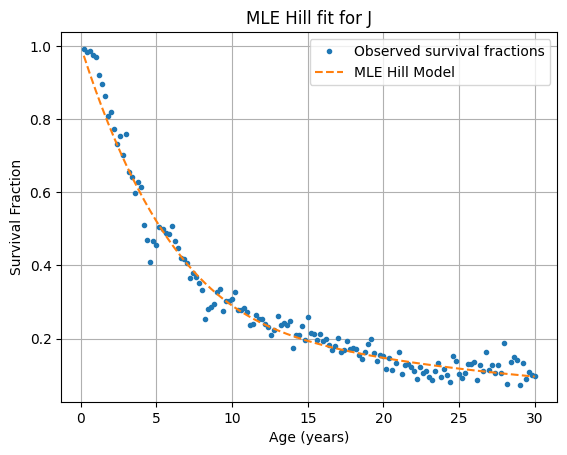

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


K: [7.24648933e-02 6.51735708e-02 1.33585285e+00 7.39690835e+01]
ll for K: -56550.17956636482


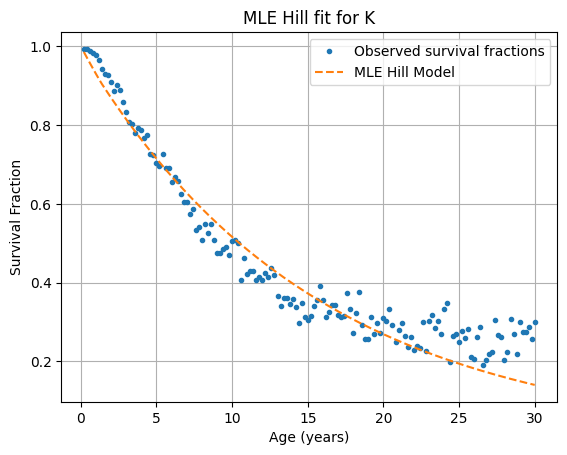

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


C: [0.10301031 0.04128293 9.26045477 8.13925264]
ll for C: -39556.72504649116


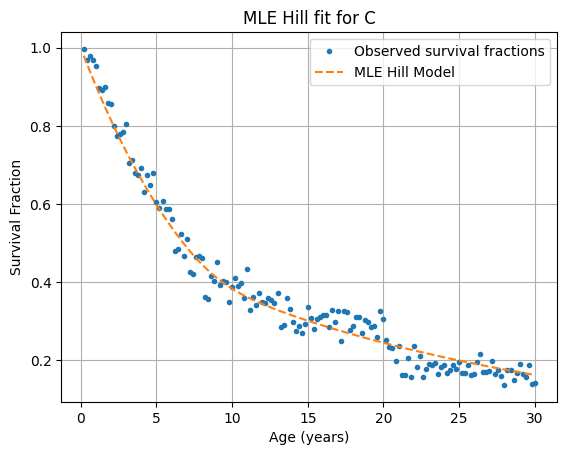

H: [1.90143914e-01 2.80160194e-02 6.93767599e+00 1.00000000e+02]
ll for H: -42974.85049611616


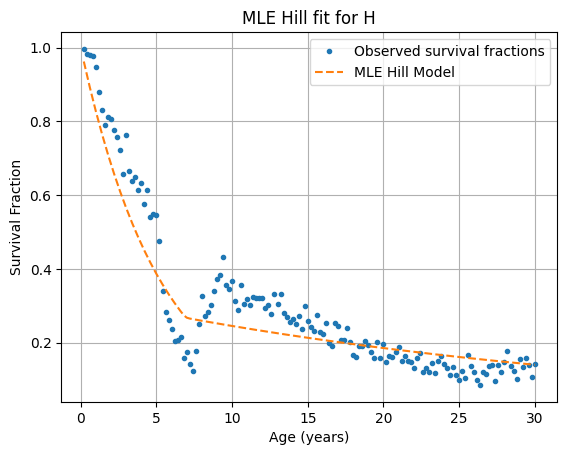

S: [1.40580290e-01 1.00000000e-10 1.29535533e+01 5.18987390e+00]
ll for S: -35752.2869350303


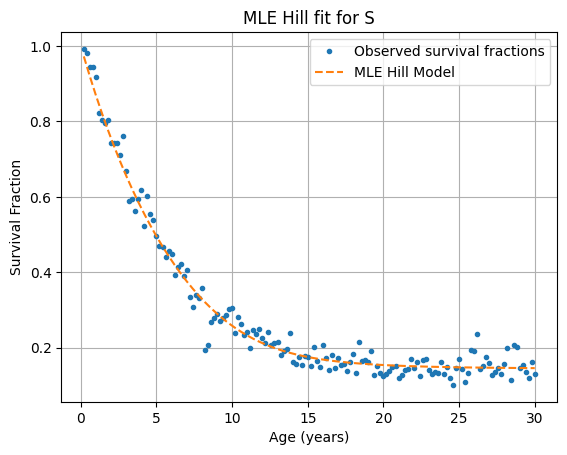

N: [1.23962230e-01 1.00000000e-10 1.64327672e+01 3.67640026e+00]
ll for N: -37012.32213218748


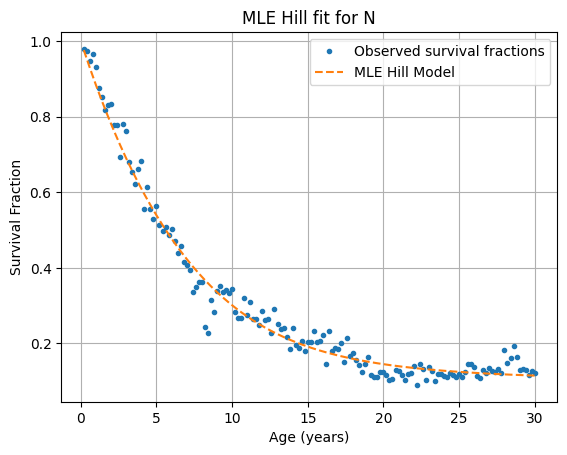

I: [ 0.12568692  0.03447114 17.44283135  5.60609428]
ll for I: -34250.503724023234


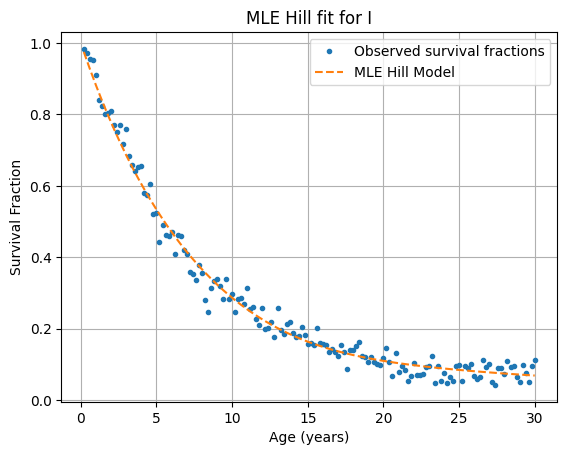

P: [1.21213526e-01 6.86842454e-02 9.44518567e+00 1.00000000e+02]
ll for P: -25155.90457508335


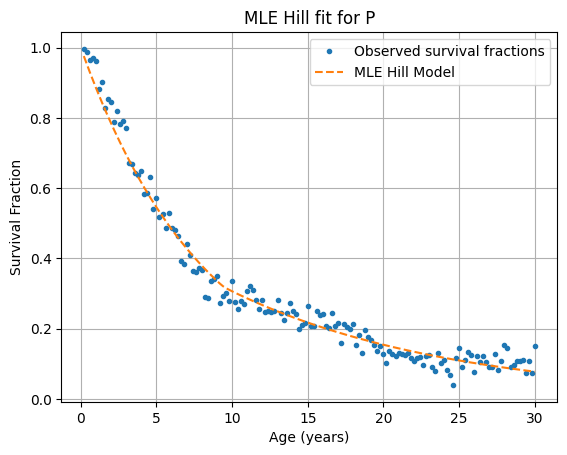

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


L: [ 0.09995713  0.06567195  2.81573161 44.85824257]
ll for L: -11970.807315497192


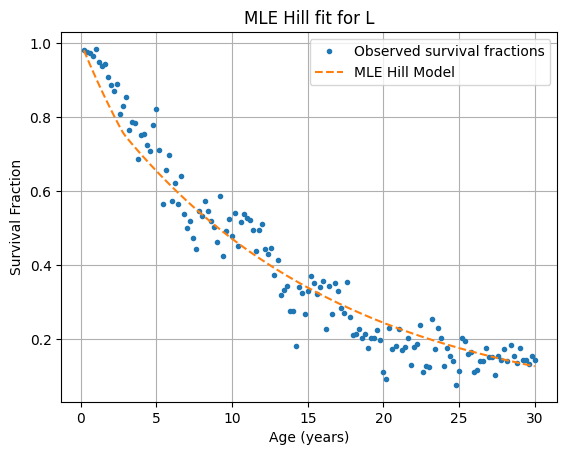

Q: [7.83015990e-02 4.71979345e-02 7.79197632e+00 1.00000000e+02]
ll for Q: -12888.580840466993


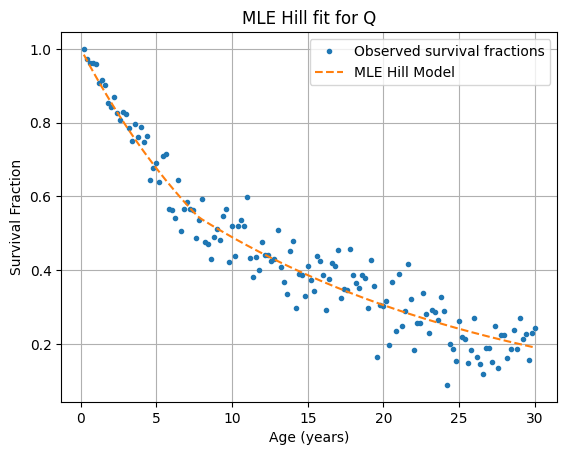

R: [1.32289514e-01 8.54857751e-02 8.85732298e+00 1.00000000e+02]
ll for R: -7519.645951813891


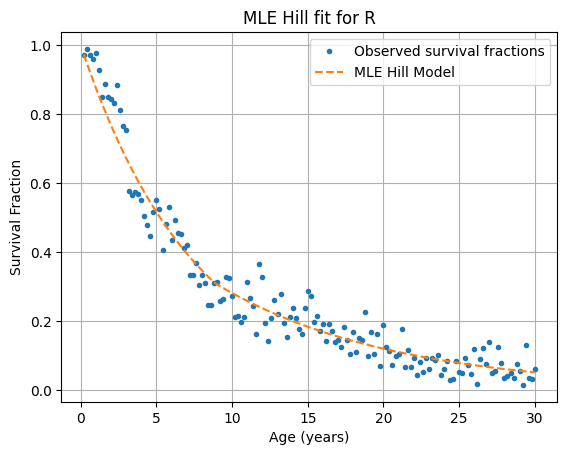

In [12]:
sector_ll_hill = []
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals)

    print(f'{fil}: {fit_hill_model_mle(ages, survivors, totals)}')

    # Plot fit
    fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')
    sector_ll_hill.append(neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    plt.title(f'MLE Hill fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

$f(a) = (1+\alpha t) ^{-\lambda / \alpha}$

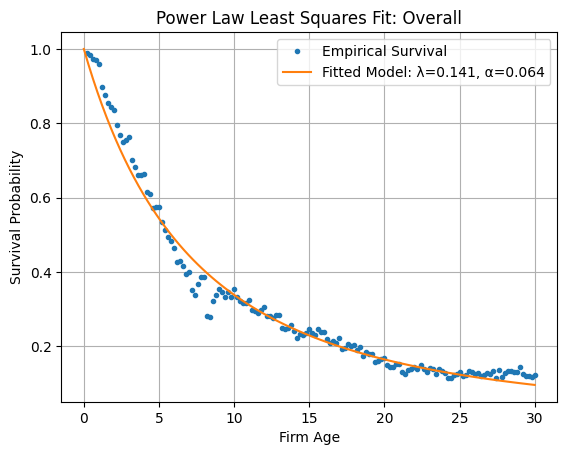

In [13]:
# ---- Closed-form survival function ----
def power_survival_function(t, lam, alpha):
    return (1 + alpha * t) ** (-lam / alpha)

# ---- Predict survival over a list of ages ----
def model_survival_curve_power(ages, lam, alpha):
    return np.array([power_survival_function(t, lam, alpha) for t in ages])

# ---- Least squares objective function ----
def objective_power(params, ages, observed_survival):
    lam, alpha = params
    if lam <= 0 or alpha < 0:
        return np.inf  # invalid parameters
    predicted = model_survival_curve_power(ages, lam, alpha)
    return np.sum((predicted - observed_survival) ** 2)

# ---- Fit the model using least squares ----
def fit_power_model(ages, survival_fractions):
    initial_guess = [0.2, 0.1]  # lambda, alpha
    bounds = [(1e-5, None), (0, None)]
    result = minimize(objective_power, initial_guess, args=(ages, survival_fractions), bounds=bounds)
    return result

# - ages: list or array of firm ages
# - survival_fractions: corresponding empirical survival fractions

# Create age bins (e.g., every 2 years)
bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)
# Compute survival fraction per bin
survival_fractions, ages = obtain_survival_fractions(df_analysis)

result = fit_power_model(ages, survival_fractions)
lam_fit, alpha_fit = result.x

# Plot result
ages_sorted = np.linspace(0, max(ages), 100)
fitted_survival = model_survival_curve_power(ages_sorted, lam_fit, alpha_fit)

plt.plot(ages, survival_fractions, 'o', markersize=3, label='Empirical Survival')
plt.plot(ages_sorted, fitted_survival, label='Fitted Model: λ=%.3f, α=%.3f' % (lam_fit, alpha_fit))
plt.xlabel("Firm Age")
plt.ylabel("Survival Probability")
plt.title("Power Law Least Squares Fit: Overall")
plt.grid(True)
plt.legend()
plt.show()


In [14]:
def neg_log_likelihood_power(params, ages, survivors, totals):
    lam, alpha = params
    if lam <= 0 or alpha <= 0:
        return np.inf

    S = power_survival_function(ages, lam, alpha)
    S = np.clip(S, 1e-12, 1 - 1e-12)  # avoid log(0)
    deaths = totals - survivors

    logL = np.sum(survivors * np.log(S) + deaths * np.log(1 - S))
    return -logL

def fit_power_model_mle(ages, survivors, totals):
    initial_guess = [0.1, 0.1]  # lam, alpha
    bounds = [(1e-6, 1), (1e-6, 1)]
    result = minimize(neg_log_likelihood_power, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result.x

ll for NR: -59567.6477521164
params lam, alpha are [0.1886195039277679, 0.18894739950045433]


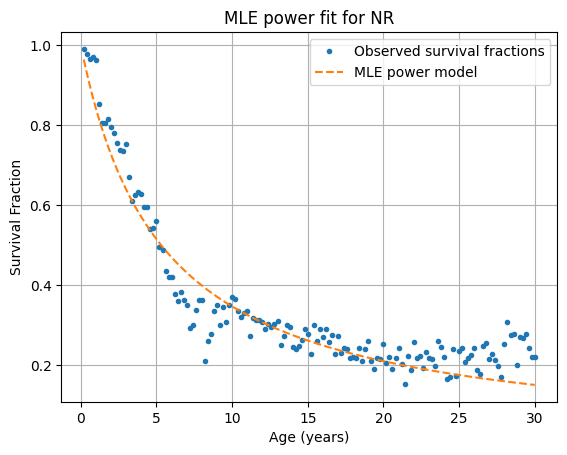

ll for WR: -96324.21879628443
params lam, alpha are [0.1889317727879867, 0.1784994064944407]


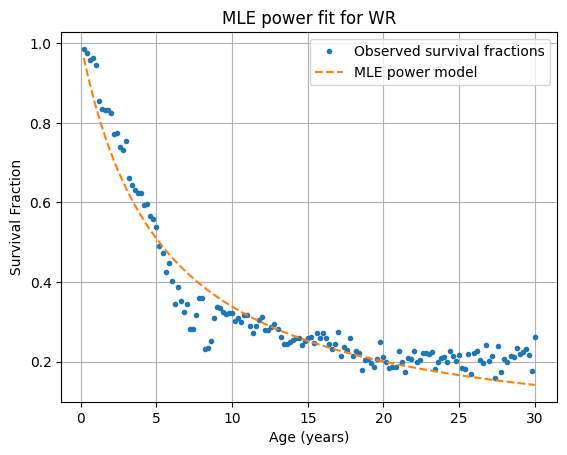

ll for CR: -420253.2008882553
params lam, alpha are [0.11069175500249837, 0.018335267155011367]


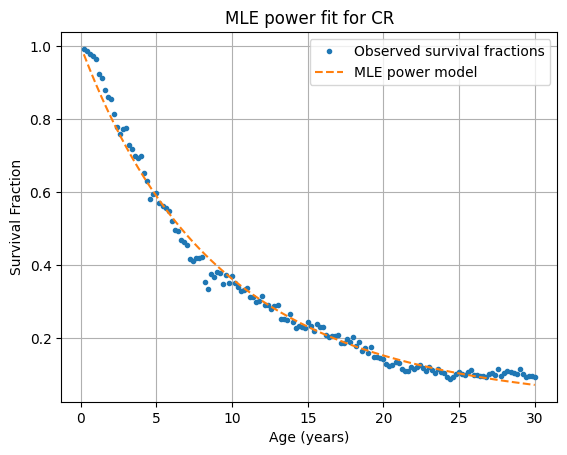

ll for ER: -71816.8062091888
params lam, alpha are [0.19149996695221363, 0.14322742737330993]


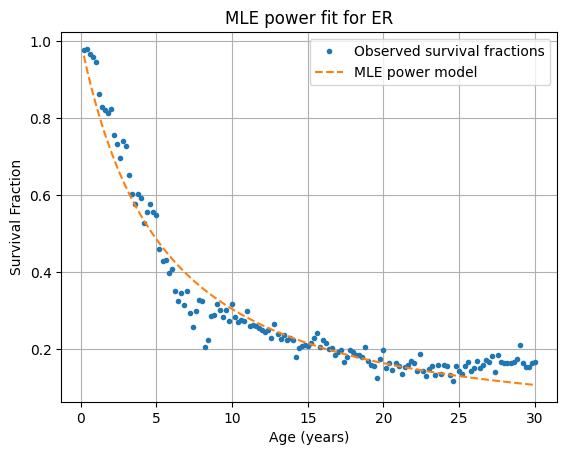

ll for NER: -82060.31237407553
params lam, alpha are [0.1989416274219653, 0.15602637405446237]


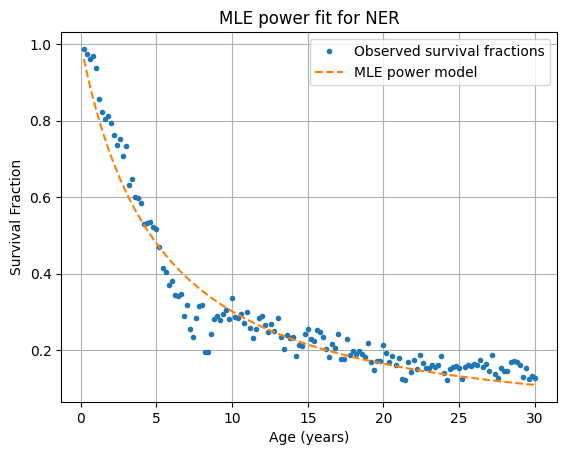

In [15]:
region_ll_power = []
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    lam, alpha = fit_power_model_mle(ages, survivors, totals)

    # Plot fit
    fitted_S = model_survival_curve_power(ages, lam, alpha)

    print(f'll for {fil}: {-neg_log_likelihood_power([lam, alpha], ages, survivors, totals)}')
    region_ll_power.append(neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

    print(f'params lam, alpha are {[float(x) for x in [lam, alpha]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
    plt.title(f'MLE power fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

ll for G: -198944.67602002577
params lam, alpha are [0.15939620292528545, 0.06554740821430066]


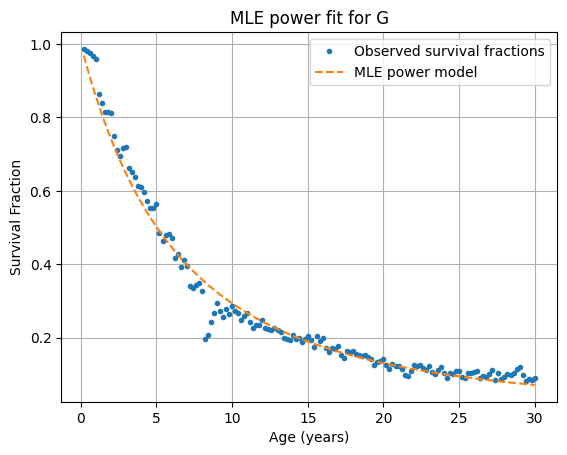

ll for M: -107109.28350819302
params lam, alpha are [0.11731541174879027, 0.034411617250405084]


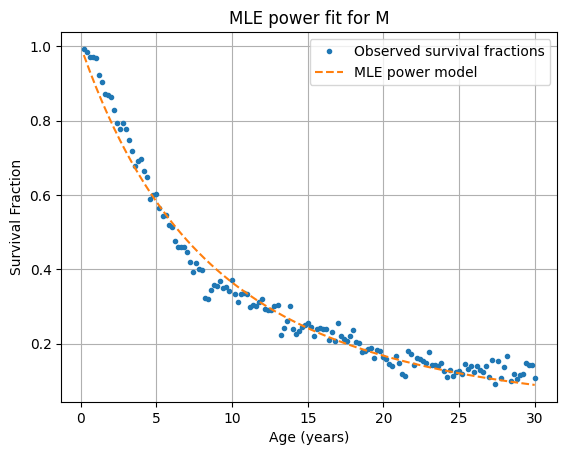

ll for F: -47789.79890249316
params lam, alpha are [0.08176472979107174, 0.003935373274942269]


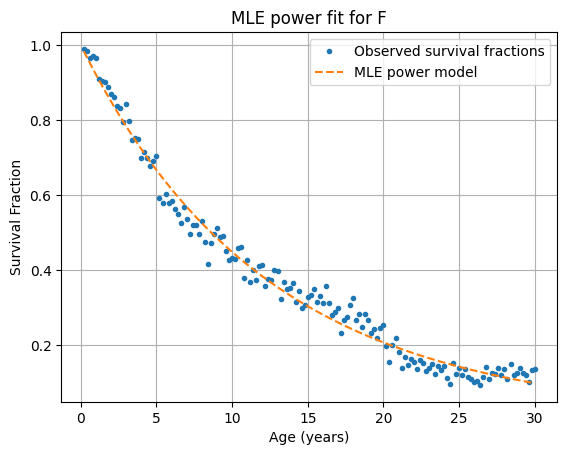

ll for J: -57151.028483457565
params lam, alpha are [0.14493123831512508, 0.05110384606085803]


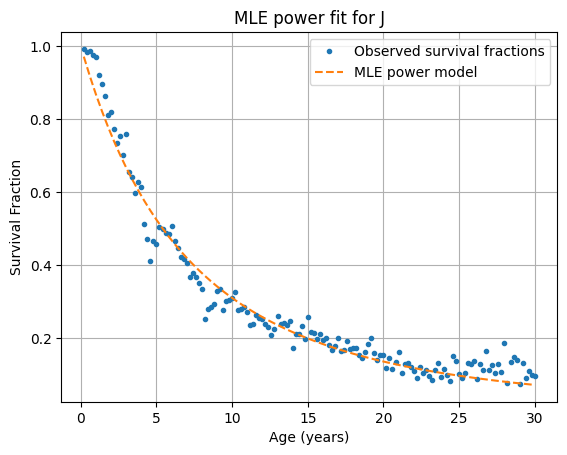

ll for K: -56413.996435860274
params lam, alpha are [0.07428516022902562, 0.0205752635062873]


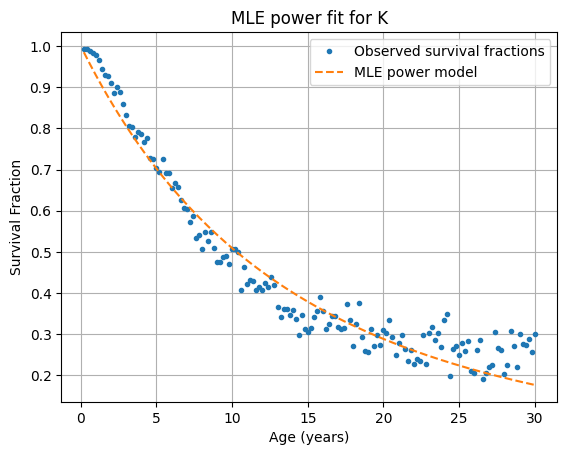

ll for C: -39594.27698304424
params lam, alpha are [0.11483004186551288, 0.06612012042977906]


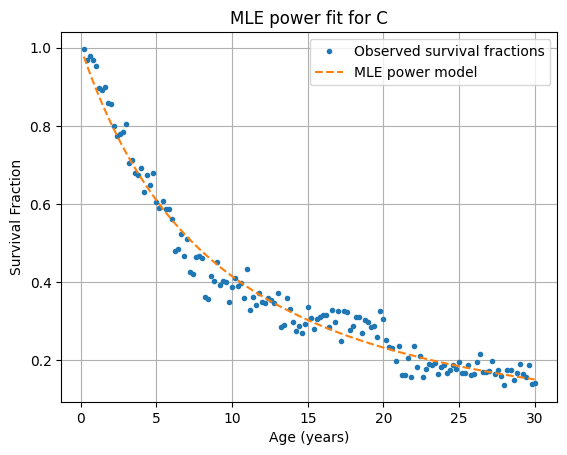

ll for H: -44001.194033551394
params lam, alpha are [0.28873886586023506, 0.2927118075549174]


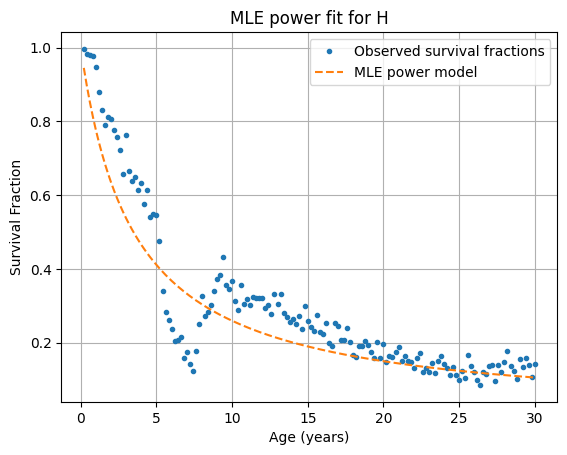

ll for S: -35960.844477007515
params lam, alpha are [0.18288352366120436, 0.11066508198985309]


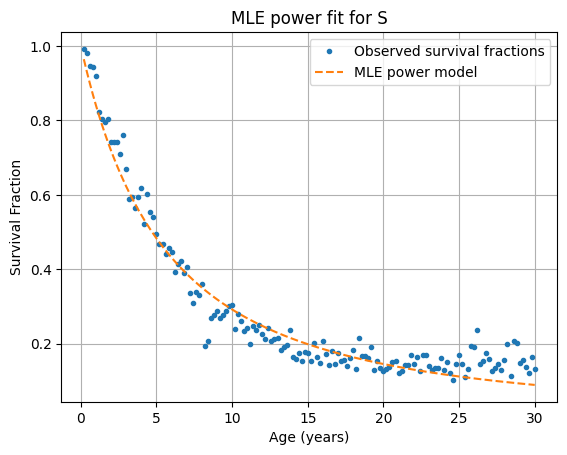

ll for N: -37101.62760374365
params lam, alpha are [0.14828698846245603, 0.06301547388836645]


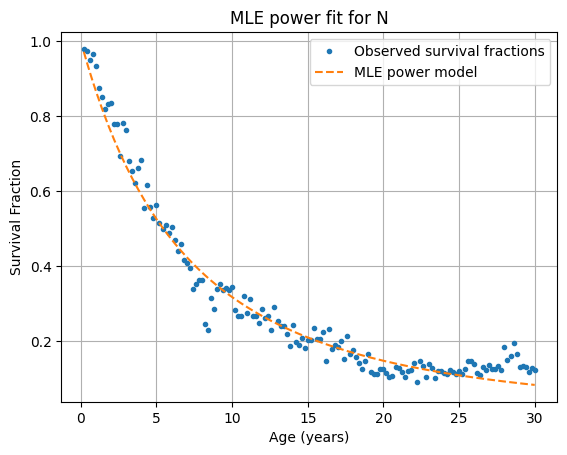

ll for I: -34289.22862246029
params lam, alpha are [0.13748459474217217, 0.026743625773472543]


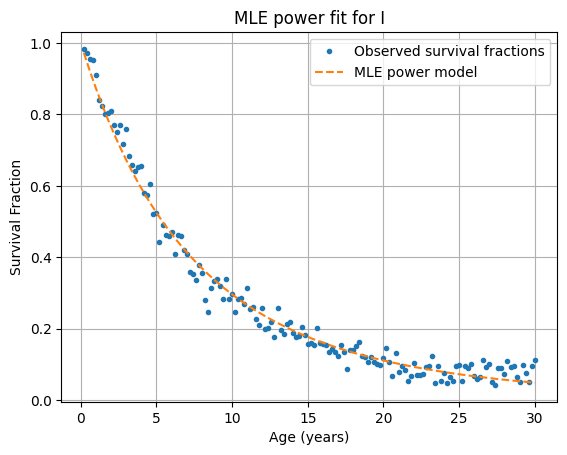

ll for P: -25212.251223789608
params lam, alpha are [0.13180537858715755, 0.03862507110559265]


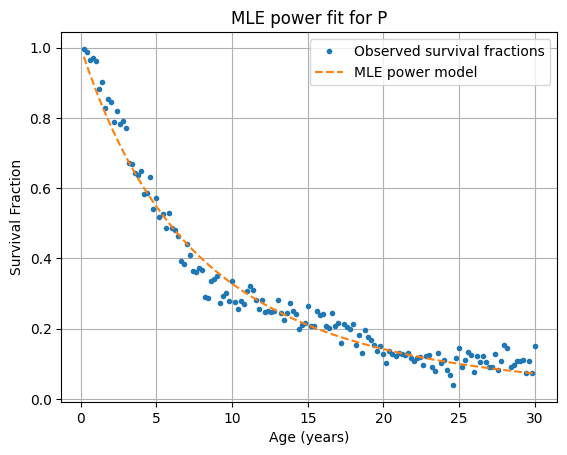

ll for L: -11928.88941323373
params lam, alpha are [0.07361777044103174, 0.0013500005115235382]


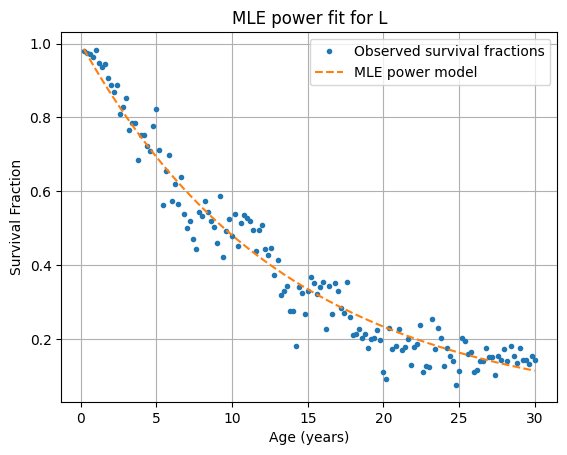

ll for Q: -12903.931859854327
params lam, alpha are [0.08504126422326021, 0.04439811725027947]


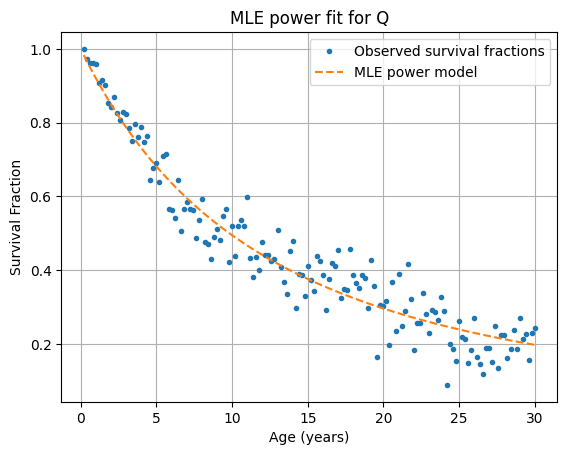

ll for R: -7533.920462008324
params lam, alpha are [0.13942475384045394, 0.02944071706324738]


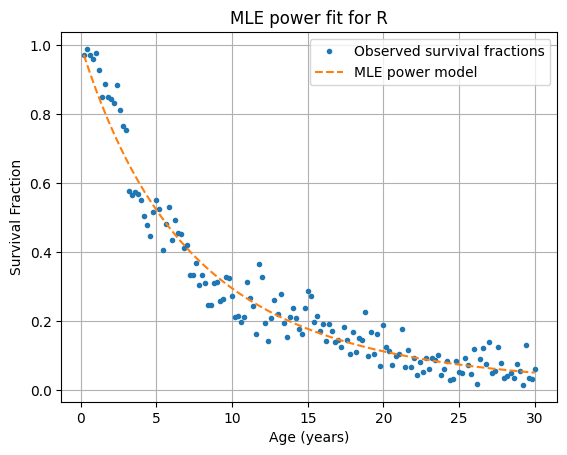

In [16]:
sector_ll_power = []

for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    lam, alpha = fit_power_model_mle(ages, survivors, totals)

    # Plot fit
    fitted_S = model_survival_curve_power(ages, lam, alpha)

    print(f'll for {fil}: {-neg_log_likelihood_power([lam, alpha], ages, survivors, totals)}')
    sector_ll_power.append(neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

    print(f'params lam, alpha are {[float(x) for x in [lam, alpha]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
    plt.title(f'MLE power fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
def compute_aic_bic(neg_logL, k, n):
    '''
    k = number of params
    n = number of observations
    '''

    aic = 2 * k + 2 * neg_logL
    bic = k * np.log(n) + 2 * neg_logL
    return aic, bic

In [32]:
region_aic_hill, region_bic_hill = compute_aic_bic(np.array(region_ll_hill), 4, len(ages))
region_aic_power, region_bic_power = compute_aic_bic(np.array(region_ll_power), 2, len(ages))

In [33]:
sector_aic_hill, sector_bic_hill = compute_aic_bic(np.array(sector_ll_hill), 4, len(ages))
sector_aic_power, sector_bic_power = compute_aic_bic(np.array(sector_ll_power), 2, len(ages))

In [20]:
def constant_survival_function(ages, mu):
    return np.exp(-mu * ages)

def model_survival_curve_constant(ages, mu):
    return np.array([constant_survival_function(_, mu) for _ in ages])

def neg_log_likelihood_constant(mu, ages, survivors, totals):
    if mu < 0:
        return np.inf
    S_vals = model_survival_curve_constant(ages, mu)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12) 
    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL

def fit_constant_model_mle(ages, survivors, totals, initial_guess=[0.01]):
    bounds = [(1e-6, None)]
    result = minimize(neg_log_likelihood_constant, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result


In [21]:
# Hill function with number of params k=3, where hill coefficient is set constant at m=5

def hill3k_hazard(a, mu_ub, mu_lb, K):
    return mu_ub - (mu_ub - mu_lb) * (a**5) / (a**5 + K**5 + 1e-10)  # Add epsilon to avoid div by 0

# ---- Step 2: Define survival function S(a) using quad integration ----

def hill3k_survival_function(a, mu_ub, mu_lb, K):
    result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)
    return np.exp(-result)

# ---- Step 3: Vectorized function to compute model survival over array of ages ----

def model_survival_curve_hill3k(ages, mu_ub, mu_lb, K):
    return np.array([hill3k_survival_function(a, mu_ub, mu_lb, K) for a in ages])

# Negative log-likelihood for binomial MLE
def neg_log_likelihood_hill3k(params, ages, survivors, totals):
    mu_ub, mu_lb, K = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0:
        return np.inf

    S_vals = model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

# Fit function
def fit_hill3k_model_mle(ages, survivors, totals, initial_guess=[0.1, 0.02, 8.0]):
    '''
    ages = vector of ages
    survivors = number of survivors in age bin
    totals = total number of firms in age bin
    initial_guess = [mu_ub, mu_lb, K]

    returns best params according to MLE
    
    '''
    bounds = [(0.01, 0.3), (1e-10, 0.2), (0.01, 30)]
    result = minimize(neg_log_likelihood_hill3k, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result

In [22]:
region_ll_hill3k = []
for fil in region_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)
    result = fit_hill3k_model_mle(ages, survivors, totals)
    print(f'params mu_ub, mu_lb, K for {fil} are {[float(x) for x in result.x]}')
    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, model_survival_curve_hill3k(ages, *result.x), label='MLE Hill3k Model', linestyle='--')
    # plt.title(f'MLE Hill3k fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    region_ll_hill3k.append(result.fun)

sector_ll_hill3k = []
for fil in sector_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)
    result = fit_hill3k_model_mle(ages, survivors, totals, [7.23785797e-02, 6.43020350e-03, 1.74446268e+01])
    print(f'params mu_ub, mu_lb, K for {fil} are {[float(x) for x in result.x]}')
    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, model_survival_curve_hill3k(ages, *result.x), label='MLE Hill3k Model', linestyle='--')
    # plt.title(f'MLE Hill3k fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    sector_ll_hill3k.append(result.fun)

region_aic_hill3k, region_bic_hill3k = compute_aic_bic(np.array(region_ll_hill3k), 3, len(ages))
sector_aic_hill3k, sector_bic_hill3k = compute_aic_bic(np.array(sector_ll_hill3k), 3, len(ages))

params mu_ub, mu_lb, K for NR are [0.13768682098344479, 0.010770197908695578, 9.069066154559453]
params mu_ub, mu_lb, K for WR are [0.13866612413271137, 0.011459381980246465, 9.452105904399511]
params mu_ub, mu_lb, K for CR are [0.10317782572240292, 1e-10, 23.443870677221483]
params mu_ub, mu_lb, K for ER are [0.14602530390843363, 0.021004753468604562, 9.859660970121507]
params mu_ub, mu_lb, K for NER are [0.15292064848485076, 0.025761231388819465, 8.751232941613194]
params mu_ub, mu_lb, K for G are [0.1369457823412897, 0.04482746273060022, 11.400350334361963]
params mu_ub, mu_lb, K for M are [0.10815483721445963, 0.046534053101995126, 12.551575296193832]
params mu_ub, mu_lb, K for F are [0.07990758927247996, 0.07259777450708982, 19.761022783579403]
params mu_ub, mu_lb, K for J are [0.13114576156109975, 0.04852501347621307, 10.762058114871234]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


params mu_ub, mu_lb, K for K are [0.0723785797, 0.0064302035, 17.4446268]
params mu_ub, mu_lb, K for C are [0.10061435059712309, 0.045621982115199085, 9.019555921816513]
params mu_ub, mu_lb, K for H are [0.1965292000339535, 0.023075820167158295, 6.8144347615635334]
params mu_ub, mu_lb, K for S are [0.14089904603201123, 1e-10, 12.922719709488728]
params mu_ub, mu_lb, K for N are [0.12139723965336907, 1e-10, 16.58567315374942]
params mu_ub, mu_lb, K for I are [0.1252053683520725, 1e-10, 20.412090901501028]
params mu_ub, mu_lb, K for P are [0.12129643770216465, 0.05989529969852383, 10.670291049379776]
params mu_ub, mu_lb, K for L are [0.07442589142109755, 0.019988859206756356, 30.0]
params mu_ub, mu_lb, K for Q are [0.07931950337645591, 0.04609385537294938, 7.6403927937991165]
params mu_ub, mu_lb, K for R are [0.13249393751659774, 0.08111059212329473, 9.513405896505404]


In [23]:
region_ll_constant = []
for fil in region_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)
    result = fit_constant_model_mle(ages, survivors, totals)
    print(result.x[0])
    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, model_survival_curve_constant(ages, result.x[0]), label='MLE Constant Model', linestyle='--')
    # plt.title(f'MLE Constant fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    region_ll_constant.append(result.fun)

sector_ll_constant = []
for fil in sector_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)
    result = fit_constant_model_mle(ages, survivors, totals)
    sector_ll_constant.append(result.fun)

region_aic_constant, region_bic_constant = compute_aic_bic(np.array(region_ll_constant), 1, len(ages))
sector_aic_constant, sector_bic_constant = compute_aic_bic(np.array(sector_ll_constant), 1, len(ages))

0.061223827326272996
0.0662859843801329
0.06757659673948377
0.07453318984129575
0.07266647379987601


In [34]:
region_df_aic = pd.DataFrame({
    'Region': region_list,
    'AIC_Hill': region_aic_hill,
    'AIC_Power': region_aic_power,
    'AIC_Hill3k': region_aic_hill3k,
    'AIC_Constant': region_aic_constant
})
region_df_aic.head()

,Region,AIC_Hill,AIC_Power,AIC_Hill3k,AIC_Constant
0,NR,118068.077116,119139.295504,118195.503403,2.582175e+07
1,WR,190914.527568,192652.437593,191089.909997,4.232045e+07
2,CR,839888.595550,840510.401777,839837.644211,2.080739e+08
3,ER,142705.091828,143637.612418,142760.381960,3.303534e+07
4,NER,162703.662051,164124.624748,162964.703743,3.751901e+07


In [ ]:
region_df_bic = pd.DataFrame({
    'Region': region_list,
    'BIC_Hill': region_bic_hill,
    'BIC_Power': region_bic_power,
    'BIC_Hill3k': region_bic_hill3k,
    'BIC_Constant': region_bic_constant
})
region_df_bic.head()

,Region,BIC_Hill,BIC_Power,BIC_Hill3k,BIC_Constant
0,NR,118080.119657,119145.316775,118204.535309,2.582176e+07
1,WR,190926.570109,192658.458863,191098.941903,4.232046e+07
2,CR,839900.638091,840516.423047,839846.676117,2.080739e+08
3,ER,142717.134369,143643.633689,142769.413866,3.303534e+07
4,NER,162715.704592,164130.646019,162973.735649,3.751902e+07


In [42]:
sector_df_aic = pd.DataFrame({
    'Sector': sector_list,
    'AIC_Hill': sector_aic_hill,
    'AIC_Power': sector_aic_power,
    'AIC_Hill3k': sector_aic_hill3k,
    'AIC_Constant': sector_aic_constant
})
sector_df_aic.head(14)

,Sector,AIC_Hill,AIC_Power,AIC_Hill3k,AIC_Constant
0,G,396775.653767,397893.352040,396727.016189,9.854523e+07
1,M,213844.852830,214222.567016,213821.041420,4.977623e+07
2,F,97069.033559,95583.597805,95590.605563,2.278440e+07
3,J,113998.288865,114306.056967,113985.691443,2.775384e+07
4,K,113108.359133,112831.992872,112481.129233,2.481625e+07
5,C,79121.450093,79192.553966,79105.046179,1.788151e+07
6,H,85957.700992,88006.388067,86635.328649,1.962410e+07
7,S,71512.573870,71925.688954,71510.756063,1.710177e+07
8,N,74032.644264,74207.255207,74040.192226,1.756619e+07
9,I,68509.007448,68582.457245,68503.782821,1.725667e+07


In [41]:
sector_df_bic = pd.DataFrame({
    'Sector': sector_list,
    'BIC_Hill': sector_bic_hill,
    'BIC_Power': sector_bic_power,
    'BIC_Hill3k': sector_bic_hill3k,
    'BIC_Constant': sector_bic_constant
})
sector_df_bic.head(14)

,Sector,BIC_Hill,BIC_Power,BIC_Hill3k,BIC_Constant
0,G,396787.696308,397899.373311,396736.048095,9.854523e+07
1,M,213856.895371,214228.588287,213830.073326,4.977624e+07
2,F,97081.076100,95589.619076,95599.637469,2.278440e+07
3,J,114010.331406,114312.078238,113994.723348,2.775384e+07
4,K,113120.401674,112838.014142,112490.161139,2.481625e+07
5,C,79133.492634,79198.575237,79114.078085,1.788151e+07
6,H,85969.743533,88012.409338,86644.360555,1.962411e+07
7,S,71524.616411,71931.710225,71519.787969,1.710178e+07
8,N,74044.686806,74213.276478,74049.224132,1.756620e+07
9,I,68521.049989,68588.478516,68512.814727,1.725667e+07


In [43]:
df_long = region_df_aic.melt(id_vars="Region", 
                  var_name="Model", 
                  value_name="AIC_Value")


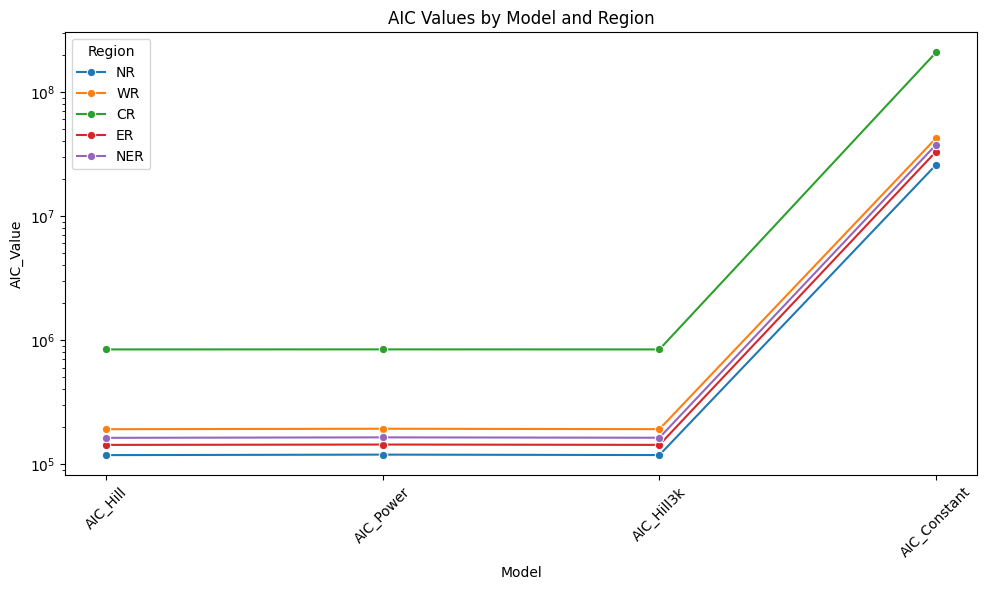

In [44]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x="Model", y="AIC_Value", hue="Region", marker="o")
plt.xticks(rotation=45)
plt.title("AIC Values by Model and Region")
plt.yscale("log")
plt.tight_layout()
plt.show()

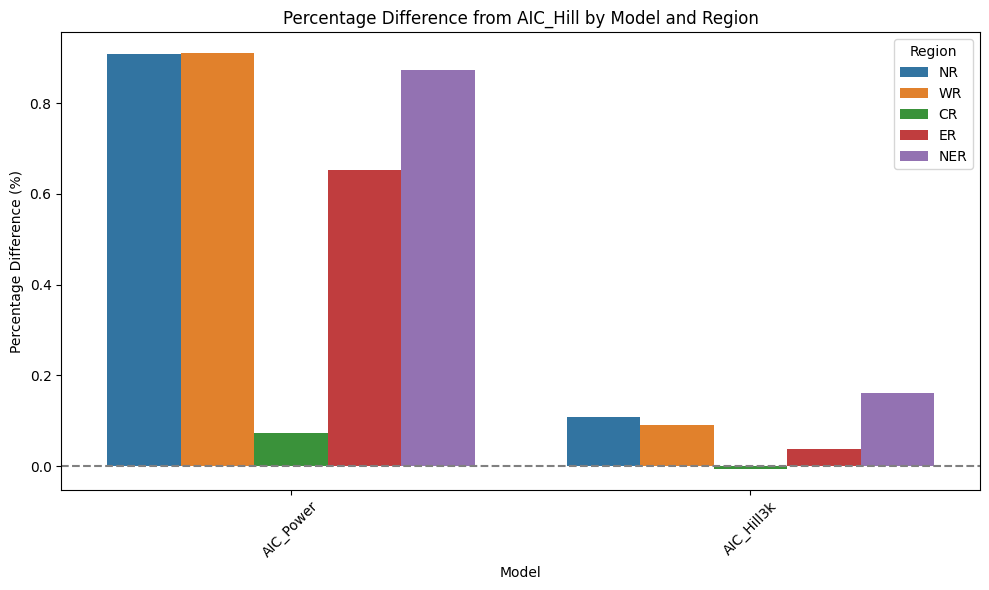

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Original AIC values
dftest = region_df_aic.copy()

# Step 1: Calculate % difference from AIC_Hill
base_model = "AIC_Hill"
compare_models = ["AIC_Power", "AIC_Hill3k"]
dftest_diff = dftest[["Region", base_model] + compare_models].copy()

# Compute percentage differences
for model in compare_models:
    dftest_diff[model] = 100 * (dftest_diff[model] - dftest_diff[base_model]) / dftest_diff[base_model]

# Step 2: Reshape for plotting
dftest_melted = dftest_diff.melt(id_vars="Region", 
                         value_vars=compare_models, 
                         var_name="Model", 
                         value_name="Percent_Diff")

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=dftest_melted, x="Model", y="Percent_Diff", hue="Region")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Percentage Difference from AIC_Hill by Model and Region")
plt.ylabel("Percentage Difference (%)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

params mu_ub, mu_lb, K, m for NR are [0.136997519985397, 0.02355779154418483, 8.313803127053902, 100.0]
params mu_ub, mu_lb, K, m for WR are [0.13907876081827764, 0.02564048511268826, 8.486260225229435, 100.0]
params mu_ub, mu_lb, K, m for CR are [0.10404007532758659, 0.050558263421044906, 17.32386546517892, 5.549887979024525]
params mu_ub, mu_lb, K, m for ER are [0.14743284942552679, 0.03815357128949517, 8.49964983319687, 100.0]
params mu_ub, mu_lb, K, m for NER are [0.1515383757283376, 0.03569624892822053, 8.275610738471816, 100.0]


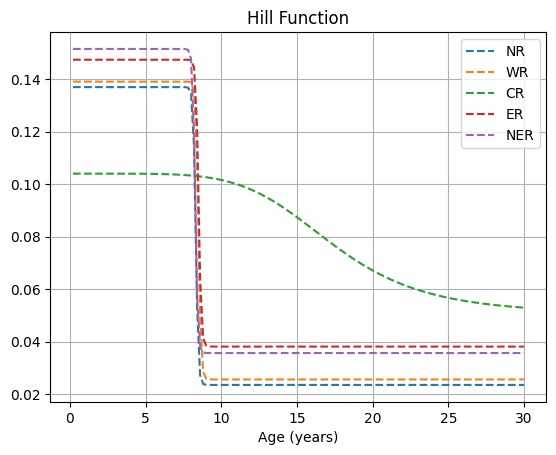

In [46]:
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals)

    print(f'params mu_ub, mu_lb, K, m for {fil} are {[float(x) for x in [mu_ub, mu_lb, K, m]]}')

    plt.plot(ages, hill_hazard(ages, mu_ub, mu_lb, K, m), label = fil, linestyle='--')
plt.title(f'Hill Function')
plt.xlabel('Age (years)')
plt.legend()
plt.grid(True)
plt.show()

params mu_ub, mu_lb, K, m for G are [0.1366002669861974, 0.03574423447261386, 12.391134242324645, 4.143563284942729]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


params mu_ub, mu_lb, K, m for M are [0.10877532595790863, 0.04180960096559574, 12.552693055107554, 4.413912216322644]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


params mu_ub, mu_lb, K, m for F are [0.1339786464964578, 0.07941961840231186, 2.9134398561377406, 42.96844048862562]
params mu_ub, mu_lb, K, m for J are [0.13090804585107477, 0.037911743247802554, 11.942980701068624, 4.056575075076045]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


params mu_ub, mu_lb, K, m for K are [0.07246489331305497, 0.06517357079652901, 1.3358528544506818, 73.96908347954856]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


params mu_ub, mu_lb, K, m for C are [0.10301031188102787, 0.04128292711458858, 9.260454772326653, 8.139252640126564]
params mu_ub, mu_lb, K, m for H are [0.19014391354561244, 0.028016019372509204, 6.937675992933932, 100.0]
params mu_ub, mu_lb, K, m for S are [0.14058028985967297, 1e-10, 12.95355328672497, 5.189873897201722]
params mu_ub, mu_lb, K, m for N are [0.12396223026938982, 1e-10, 16.432767196404157, 3.676400256259959]
params mu_ub, mu_lb, K, m for I are [0.12568691970264143, 0.03447114109235658, 17.4428313461289, 5.606094278968607]
params mu_ub, mu_lb, K, m for P are [0.12121352602907308, 0.06868424543482243, 9.445185667957643, 100.0]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


params mu_ub, mu_lb, K, m for L are [0.09995712759231856, 0.06567194916577264, 2.815731606085221, 44.858242572175094]
params mu_ub, mu_lb, K, m for Q are [0.07830159902966662, 0.04719793450035197, 7.791976315346411, 100.0]
params mu_ub, mu_lb, K, m for R are [0.13228951419617163, 0.08548577511481936, 8.857322980393356, 100.0]


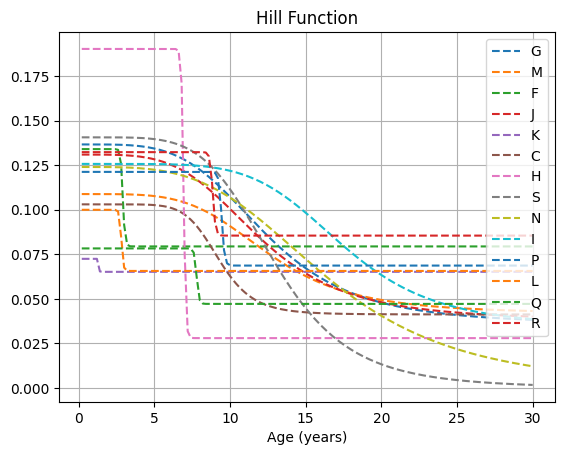

In [48]:
for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals)

    print(f'params mu_ub, mu_lb, K, m for {fil} are {[float(x) for x in [mu_ub, mu_lb, K, m]]}')

    plt.plot(ages, hill_hazard(ages, mu_ub, mu_lb, K, m), label = fil, linestyle='--')
plt.title(f'Hill Function')
plt.xlabel('Age (years)')
plt.legend()
plt.grid(True)
plt.show()

I need to increase the upper bounds for m

plot hill functions

compare parameters between MLE and LSE